In [1]:
import numpy as np
import sys
sys.path+=['../']
from IntegrableResonanceModel import IntegrableResonanceModel
from scipy.optimize import root_scalar
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
%matplotlib inline

/Users/shadden/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#**** Note *******
# Computing accurate secular frequencies can
# require increasing the number of quadrature points
# above the default
res_model = IntegrableResonanceModel(3,1,n_quad_pts=61)

In [3]:
from IntegrableModelUtils import calc_action_and_frequencies

# Generate set of initial condtions with different $\cal J^*$ at constant $\cal J$
We'll start by finding the ${\cal J}$ value that corresponds to the nominal location of secular resonance at a user-specified value of ${\cal J}^*$. The user specifies ${\cal J}^*$ by defining  the corresponding value of eccentricity as $Z/Z_{cross}=$`zf`. The resonance location is found by calculating the secular frequency as a function of intial libration amplitude and using root-finding to locate $\Omega_\text{sec} =0$

In [4]:
a_s,b_s,c_s = res_model.secular_coeffs()
eps_bs = b_s * res_model.eps

In [5]:
zf = 0.2 # set 'zf'
_,_,Z = res_model.get_z1z2Z_from_zfrac(zf) # convert to Z
Jstar = res_model.Zsq_to_J * (Z)**2 # convert 'zf' to a value of Jstar
yell = res_model.elliptic_fixed_point(Jstar) # find elliptic point

# Calculate initial conditions as a function of libration amplitude
calc_ics = lambda librationAmplitude:  yell + np.array([librationAmplitude,0,0,0])
calc_Omega_sec = lambda librationAmplitude: eps_bs + calc_action_and_frequencies(
    calc_ics(librationAmplitude),
    res_model)[2]

# FInd libration amplitude where Omega_sec = 0 
root = root_scalar(calc_Omega_sec,bracket=[2.,2.9])

In [6]:
ics = yell + np.array([root.root,0,0,0])
action0,_,_=calc_action_and_frequencies(ics,res_model)

Now we'll find initial conditions with different values of ${\cal J}^*$ and the same value of ${\cal J}$

In [7]:
ics = []

zfs = np.linspace(0.15,0.4,10)


for zf in np.linspace(0.15,0.4,10):
    _,_,Z = res_model.get_z1z2Z_from_zfrac(zf)
    Jstar = res_model.Zsq_to_J * (Z)**2
    yell = res_model.elliptic_fixed_point(Jstar)
    calc_ics = lambda librationAmplitude:  yell + np.array([librationAmplitude,0,0,0])
    calc_action = lambda librationAmplitude: calc_action_and_frequencies(calc_ics(librationAmplitude),res_model)[0]
    calc_delta_action = lambda librationAmplitude: calc_action(librationAmplitude)-action0
    try:
        root = root_scalar(calc_delta_action,bracket=[1.,3])
    except ValueError:
        print("Failed for zf ={:.2f}. Try changing the bracketing values for the root.".format(zf))
        break
    if root.converged:
        ics.append(calc_ics(root.root))

ics = np.array(ics)

A quick look at the set of initial conditions we've generated

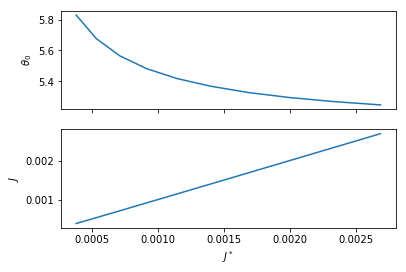

In [8]:
fig,ax = plt.subplots(2,sharex=True)
ax[0].plot(ics[:,3] , ics[:,0])
ax[1].plot(ics[:,3] , ics[:,2])
ax[0].set_ylabel(r"$\theta_0$")
ax[1].set_ylabel(r"$J$")
ax[1].set_xlabel(r"$J^*$")

We'll set up an interpolation to get intial conditions of constant ${\cal J}$ as a functions of ${\cal J}^*$

In [9]:
from scipy.interpolate import CubicSpline
ics_vs_zfrac = CubicSpline(zfs,ics)

#  $H_\text{pert}$ function
Compile function to compute
$$
            H_\text{pert}(J,\theta,J^*,\theta^*)= \epsilon b_s J^* -\epsilon c_s\sqrt{J({\cal A} - J^*)}\cos(\theta+\theta^*)
            $$

In [10]:
import theano
import theano.tensor as T

dyvars = T.vector()
calA,b_s,c_s,eps = T.dscalars(4)
theta,theta_star,J,J_star = [dyvars[i] for i in range(4)]
_Fpert = eps * b_s * J_star -  eps * c_s * T.sqrt(J) * T.sqrt(calA - J_star)  * T.cos(theta+theta_star)
Fpert = theano.function(
    inputs=[dyvars,calA,b_s,c_s,eps],
    outputs=_Fpert
   )
gradFpert = theano.function(
    inputs=[dyvars,calA,b_s,c_s,eps],
    outputs=theano.grad(_Fpert,wrt=dyvars)
   )
hessFpert = theano.function(
    inputs=[dyvars,calA,b_s,c_s,eps],
    outputs=theano.gradient.hessian(_Fpert,wrt=dyvars)
   )

In [11]:
calA = 2 * ics_vs_zfrac(0.2)[3]
_,b_s,c_s = res_model.secular_coeffs()
Energy = np.zeros((50,50))
zfs = np.linspace(0.15,0.4)
theta_plus_thetastars = np.linspace(-np.pi,np.pi)
for i,zf in enumerate(zfs):
    for j,theta_plus_thetastar in enumerate(theta_plus_thetastars):
        y = ics_vs_zfrac(zf)
        y[1] = theta_plus_thetastar - y[0]
        Energy[i,j] = res_model.H(y)+Fpert(y,calA,b_s,c_s,res_model.eps)


(0.15, 0.4)

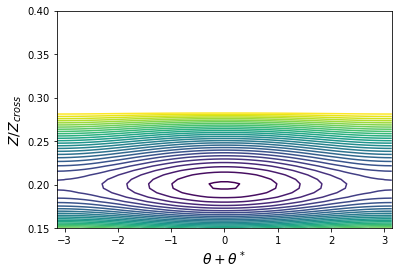

In [12]:
X,Y = np.meshgrid(theta_plus_thetastars,zfs)
plt.contour(X,Y,Energy,30)
plt.xlabel(r"$\theta+\theta^*$",fontsize=14)
plt.ylabel(r"$Z/Z_{cross}$",fontsize=14)
plt.ylim()

In [13]:
sims = []
Energies = []
for zf in [0.17,0.2]:
    y = ics_vs_zfrac(zf)
    y[1] = -2 - y[0]
    Energies.append(res_model.H(y)+Fpert(y,calA,b_s,c_s,res_model.eps))
    sims.append(res_model.dyvars_to_rebound_sim(y,calA = calA,P2 = 2*np.pi))

In [14]:
time = np.linspace(0,3e4 * sims[0].particles[2].P,150)

In [16]:
els = np.zeros((2,len(time),2,4))
for i,t in enumerate(time):
    for k,sim in enumerate(sims):
        sim.integrate(t)
        for j,p in enumerate(sim.particles[1:]):
            els[k,i,j] = p.P,p.e,p.l,p.pomega

(0.15, 0.25)

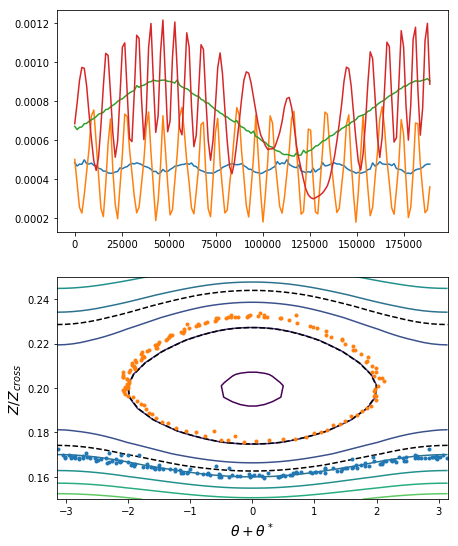

In [17]:
fig,ax = plt.subplots(2,1,figsize=(7,9))
_,_,Zcross = res_model.get_z1z2Z_from_zfrac(1)
X,Y = np.meshgrid(theta_plus_thetastars,zfs)
ax[1].contour(X,Y,Energy,10)
ax[1].contour(X,Y,Energy,np.sort(Energies),colors=['k'])


for k in range(2):
    z1,z2 = np.transpose(els[k,:,:,1] * np.exp(1j * els[k,:,:,3]))

    Mmtrx = res_model._get_M_matrix()

    rtPhi_exp_iphi,rtPsi_exp_ipsi = np.conjugate(np.linalg.inv(Mmtrx).dot([z1,z2]))

    J = np.abs(rtPhi_exp_iphi)**2

    l1,l2=np.transpose(els[k,:,:,2])

    P1,P2=np.transpose(els[k,:,:,0])

    Delta = (res_model.j - res_model.k) * P2 / P1 / res_model.j - 1

    Jstar = J-Delta / res_model.dJ_to_Delta

    Q = res_model.j * l2 - (res_model.j-res_model.k) * l1

    theta = (Q + res_model.k * np.angle(rtPhi_exp_iphi)) / res_model.k
    thetaStar = -1 * (Q + res_model.k * np.angle(rtPsi_exp_ipsi)) / res_model.k
    
    ax[0].plot(time,Jstar)
    ax[0].plot(time,J)
    
    ax[1].plot(np.mod(theta+thetaStar+np.pi,2*np.pi)-np.pi,np.sqrt(Jstar/res_model.Zsq_to_J)/Zcross,'.')
ax[1].set_xlabel(r"$\theta+\theta^*$",fontsize=14)
ax[1].set_ylabel(r"$Z/Z_{cross}$",fontsize=14)
ax[1].set_ylim(ymax = 0.25)

In [ ]:
from scipy.integrate import solve_ivp
from IntegrableModelUtils import getOmegaMatrix
OmegaMtrx = getOmegaMatrix(2)
def ydot(t,y):
    return res_model.flow_vec(y) + OmegaMtrx.dot(gradFpert(y,calA,b_s,c_s,res_model.eps))
def ydot_jac(t,y):
    return res_model.flow_jac(y) + OmegaMtrx.dot(hessFpert(y,calA,b_s,c_s,res_model.eps))

In [18]:
sol =solve_ivp(ydot,
          (0,100),
          y0=y,
          method='Radau',
          dense_output=True,
          jac = ydot_jac
         )